# Stochastic, Mini batch e Full batch Gradient Descent
In questo notebook faremo un confronto tra le tre varianti dell'algoritmo di ottimizzazione Gradient Descent
 * **Full Batch**: Il gradient descent utilizza tutti gli esempi per correggere i coefficienti.
 * **Stochastic**: Il gradient descent utilizza un solo esempio per volta per correggere i coefficienti.
 * **Mini Batch**: Il gradient descent utilizza un determinato numero di esempi per volta per coreggere i coefficienti.
 
Per questo esempio utilizzeremo il dataset [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist), un dataset contenente capi di abbigliamento correttamente classificati, creato dalla popolare piattaforma di e-commerce Zalando.
<br>
<br>
Cominciamo importando i moduli che ci serviranno

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense

from time import time

#from scripts.random import set_seed # da utilizzare per poter riprodurre i miei risultati

## Preparazione dei dati
Piuttosto che scaricare i files in formato binario dalla repository, possiamo caricare il dataset utilizzando l'utility inclusa in Keras.

In [3]:
from keras.datasets import fashion_mnist

labels = ["T-shirt/top","Pantalone","Pullover","Vestito","Cappotto","Sandalo","Maglietta","Sneaker","Borsa","Stivaletto"]

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

print("Numero totale di proprietà: "+str(X_train.shape[1]))
print("Esempi di training: "+str(X_train.shape[0]))
print("Esempi di test: "+str(X_test.shape[0]))

4422102/4422102 [==============================] - 2s 0us/step
Numero totale di proprietà: 28
Esempi di training: 60000
Esempi di test: 10000


Le immagini appartengono ad una delle seguenti classi: *T-shirt/top, Pantalone, Pullover, Vestito, Cappotto, Sandalo, Maglietta, Sneaker, Borsa, Stivaletto*.
<br><br>
Ogni immagine è rappresentata da una matrice di 28x28 pixel, proviamo a visualizzare la prima osservazione del test set utilizzando la funzione <span style="font-family: Monaco">imshow</span> di matplotlib.

L'immagine figura un/o Stivaletto


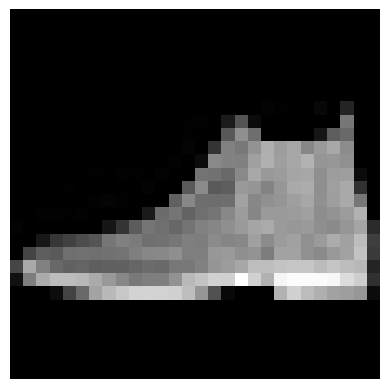

In [4]:
plt.axis("off")
plt.imshow(X_test[0], cmap="gray")
print("L'immagine figura un/o %s" % labels[y_test[0]])

Dato che una singola osservazione è una matrice, dobbiamo spacchettare le righe all'interno di un singolo vettore. Per farlo possiamo utilizzare il metodo <span style="font-family: Monaco">reshape</span>.

In [5]:
X_train = X_train.reshape(X_train.shape[0],28*28)
X_test = X_test.reshape(X_test.shape[0],28*28)

X_train.shape

(60000, 784)

Ogni pixel dell'immagine ha un valore che va da 0 a 255, eseguiamo la normalizzazione per ridurre questi valori in una scala da 0.0 a 1.0.

In [6]:
print("Prima della normalizzazione")
print("Valore massimo: %d" % X_train.max())

X_train = X_train/255
X_test = X_test/255

print("Dopo la normalizzazione")
print("Valore massimo: %d" % X_train.max())

Prima della normalizzazione
Valore massimo: 255
Dopo la normalizzazione
Valore massimo: 1


Passiamo agli array con i target, questi contengono un valore numerico che va da 0 a 9, il quale rappresenta la categoria di appartenenza dell'articolo raffigurato nell'immagine, tra quelle elencate sopra.<br>
Per poter eseguire una classificazione multiclasse dobbiamo creare 10 variabili dummy per ogni osservazione, una per ogni classe. Possiamo farlo utilizzando la funzione <span style="font-family: Monaco">to_categorical</span> di Keras.
Ciò viene fatto perchè essendo una classificazione multiclasse si una come funzione di attivazione del nodo di output la funzione softmax.

In [7]:
from keras.utils import to_categorical

num_classes=10

y_train_dummy = to_categorical(y_train, num_classes)
y_test_dummy = to_categorical(y_test, num_classes)

## Full batch Gradient Descent
Cominciamo dal Full batch Gradient Descent. Per prima cosa creiamo il modello, possiamo utilizzare la stessa architettura che abbiamo utilizzato in un notebook precedente per il MNIST.

In [8]:
#set_seed(0) # per poter riprodurre i miei risultati

model = Sequential()
model.add(Dense(512, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

Diamo uno sguardo al numero totale di parametri che il Full Batch Gradient Descent dovrà ottimizzare.

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
Total params: 567434 (2.16 MB)
Trainable params: 567434 (2.16 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Sono oltre mezzo milione, diposti su 3 strati. Prepariamo il modello per l'addestramento con il metodo <span style="font-family: Monaco">compile</span>, come ottimizzatore specifichiamo sempre lo stochastic gradient descent (si, lo so che il nostro scopo è utilizzare il full batch, ma fidati di me :) )

In [10]:
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

Adesso, per utilizzare il full batch gradient descent, non dobbiamo far altro che specificare all'interno del metodo  <span style="font-family: Monaco">fit</span> che la dimensione di un batch deve essere pari al numero di osservazioni nel set di addestramento, in tal modo l'algoritmo di ottimizzazione utilizzerà un unico batch con tutte le osservazioni ad ogni iterazione del gradient descent.
<br>
Per poter costruire un grafico della funzione di costo ad ogni epoca dobbiamo tener traccia di questi valori, per farlo dobbiamo definire un callback.

In [11]:
# history serve per memorizzare i valori di addestramento così da poterli usare per tracciarne il grafico
from keras.callbacks import History 
history = History()

#loss: 2.0902 - acc: 0.3302

#batch size indica il numero di esempi che prende la rete per eseguire il gradient descent ad ogni step

# time mi dice quanto tempo impiega la rete per addestrarsi
start_at = time()
model.fit(X_train, y_train_dummy, epochs=10, batch_size=X_train.shape[0], callbacks=[history])
exec_time = time() - start_at

print("Tempo di addestramento: %d minuti e %d secondi" % (exec_time/60, exec_time%60))

Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 2.3759 - accuracy: 0.0701
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 2.3481 - accuracy: 0.0821
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 2.3229 - accuracy: 0.0941
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 2.2998 - accuracy: 0.1056
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 2.2784 - accuracy: 0.1166
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 2.2584 - accuracy: 0.1276
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 2.2395 - accuracy: 0.1392
Epoch 8/10
1/1 [==============================] - 2s 2s/step - loss: 2.2216 - accuracy: 0.1507
Epoch 9/10
1/1 [==============================] - 2s 2s/step - loss: 2.2046 - accuracy: 0.1641
Epoch 10/10
1/1 [==============================] - 1s 1s/step - loss: 2.1883 - accuracy: 0.1805
Tempo di addestramento: 0 minuti e 21 secondi


I risultati del modello sono piuttosto scarsi, perché le 100 epoche non erano sufficenti a portare alla convergenza, infatti con ulteriori epoche il modello avrebbe continuato a migliorare.
<br>
Utilizziamo i valori della funzione di costo raccolti per visualizzare la sua variazione a ogni epoche su di un grafico.

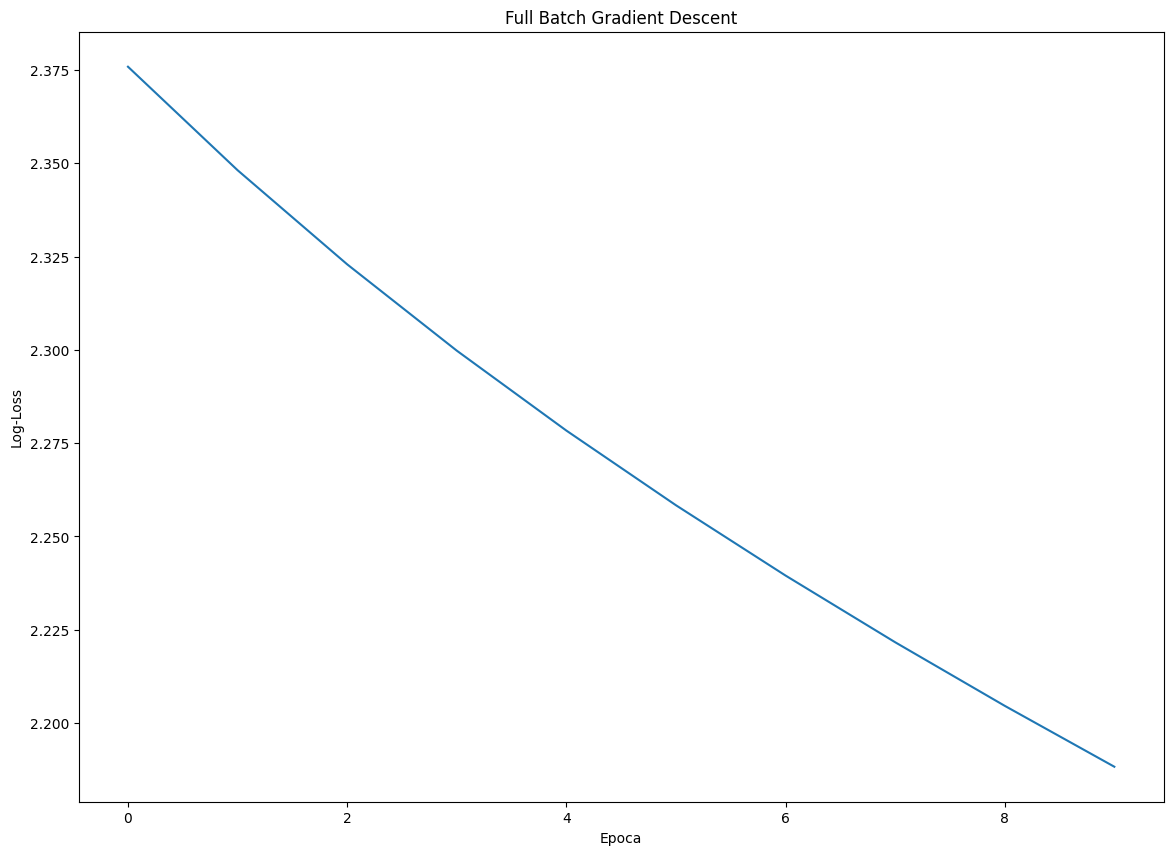

In [13]:
plt.figure(figsize=(14,10))
plt.title("Full Batch Gradient Descent")
plt.xlabel("Epoca")
plt.ylabel("Log-Loss")
plt.plot(history.history['loss'])

#come si puo notare, la funzione di costo non ha oscillazioni, ma è sempre decrescente

Come possiamo osservare, l'errore del modello si è ridotto in maniera abbastanza pulita senza oscillazioni.

## Stochastic Gradient Descent
Passiamo adesso all'estremo opposto del Gradient Descent: lo Stochastic Gradient Descent.<br>
Cominciamo ricostruendo lo stesso modello.

In [14]:
model = Sequential()
model.add(Dense(512, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

Perché abbiamo dovuto ridefinire di nuovo lo stesso modello di prima ? Perché altrimenti, chiamando il metodo <span style="font-family: Monaco">fit</span> l'addestramento sarebbe ripartito da dove si era fermato all'esecuzione precedente, continuando a ottimizzare i coefficienti che già aveva trovato.
<br>
<br>
Compiliamo il modello, esattamente come fatto prima.

In [15]:
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

Adesso, per utilizzare lo Stochastic Gradient Descent, impostiamo come dimensione del singolo batch 1, in modo tale da far utilizzare all'algoritmo di ottimizzazione un esempio per volta. Facendo questo il gradient descent ad ogni epoca viene eseguito un numero di volte pari al numero di esempi nel set di addestramento (nel nostro caso 60.000), ne segue che il completamento di un'epoca richiederà molto più tempo rispetto al full batch. Per questo motivo impostiamo il numero di epoche a 5.

In [16]:
start_at = time()
model.fit(X_train, y_train_dummy, epochs=3, batch_size=1)
exec_time = time() - start_at

print("Tempo di addestramento: %d minuti e %d secondi" % (exec_time/60, exec_time%60))

Epoch 1/3
60000/60000 [==============================] - 303s 5ms/step - loss: 0.5091 - accuracy: 0.8125
Epoch 2/3
60000/60000 [==============================] - 251s 4ms/step - loss: 0.3859 - accuracy: 0.8579
Epoch 3/3
60000/60000 [==============================] - 223s 4ms/step - loss: 0.3491 - accuracy: 0.8702
Tempo di addestramento: 12 minuti e 58 secondi


Nel mio caso, l'esecuzione di 5 epoche di stochastic gradient descent ha richiesto 4 volte il tempo del full batch, ma l'addestramento si è concluso con un risultato decisamente migliore.

## Mini Batch Gradient Descent
Completiamo eseguendo la versione intermedia del Gradient Descent e anche quella più consigliata da utilizzare: il Mini Batch Gradient Descent.
<br>
Ricreiamo il modello e compiliamolo.

In [17]:
model = Sequential()
model.add(Dense(512, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [18]:
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

E adesso specifichiamo all'interno del metodo <span style="font-family: Monaco">fit</span> la dimensione di ogni batch, i valori consigliati sono 32, 64, 128, 256 e 512.<br>
Optiamo per 512.

In [22]:
from keras.callbacks import History 
history = History()

start_at = time()
model.fit(X_train, y_train_dummy, epochs=100, batch_size=512, callbacks=[history])
exec_time = time() - start_at

print("Tempo di addestramento: %d minuti e %d secondi" % (exec_time/60, exec_time%60))

Epoch 1/100
118/118 [==============================] - 3s 22ms/step - loss: 0.2997 - accuracy: 0.8933
Epoch 2/100
118/118 [==============================] - 3s 22ms/step - loss: 0.2983 - accuracy: 0.8953
Epoch 3/100
118/118 [==============================] - 3s 25ms/step - loss: 0.2981 - accuracy: 0.8951
Epoch 4/100
118/118 [==============================] - 2s 20ms/step - loss: 0.2969 - accuracy: 0.8960
Epoch 5/100
118/118 [==============================] - 3s 24ms/step - loss: 0.2969 - accuracy: 0.8964
Epoch 6/100
118/118 [==============================] - 3s 25ms/step - loss: 0.2939 - accuracy: 0.8969
Epoch 7/100
118/118 [==============================] - 3s 22ms/step - loss: 0.2954 - accuracy: 0.8953
Epoch 8/100
118/118 [==============================] - 3s 25ms/step - loss: 0.2951 - accuracy: 0.8963
Epoch 9/100
118/118 [==============================] - 3s 26ms/step - loss: 0.2932 - accuracy: 0.8965
Epoch 10/100
118/118 [==============================] - 3s 22ms/step - loss: 0.293

Il mini batch con un batch size di 512 ha richiesto poco più tempo del full batch e ha portato a un risultato finale decisamente migliore.
Visualizziamo la variazione dell'errore ad ogni epoca.

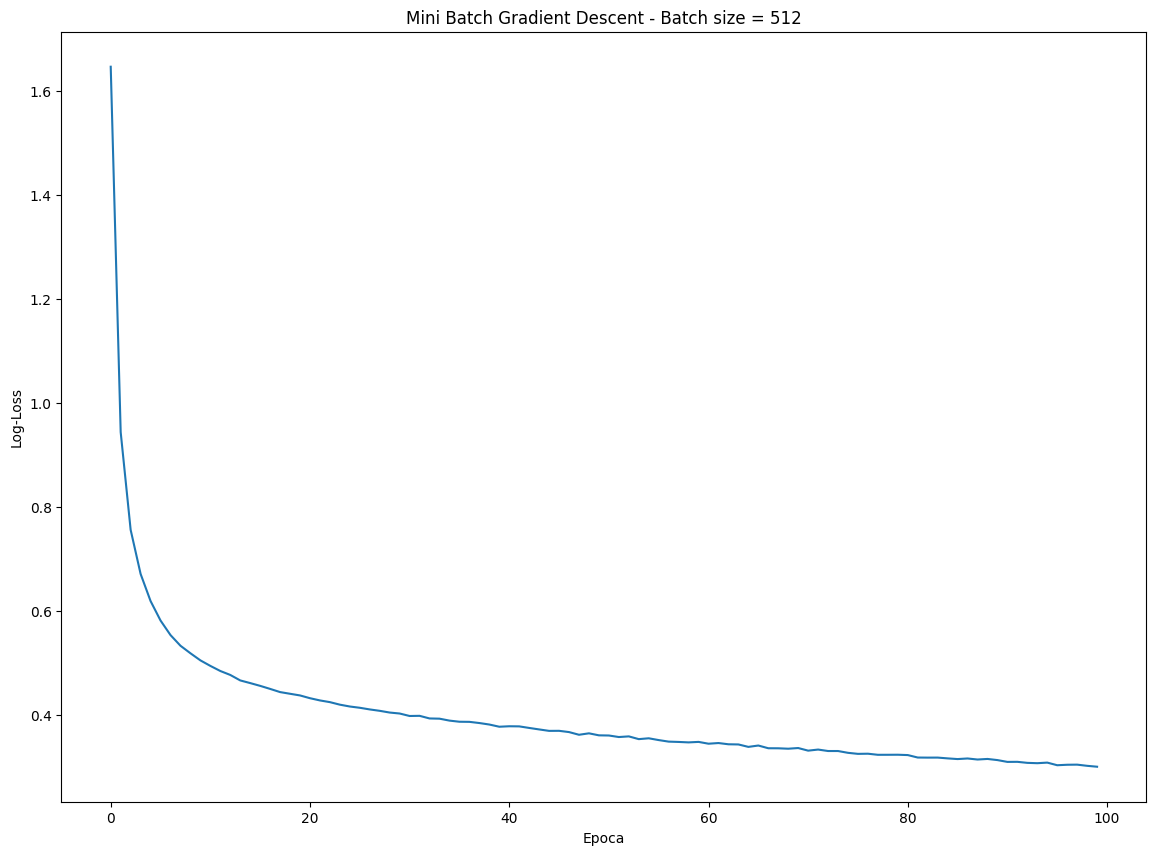

In [20]:
plt.figure(figsize=(14,10))
plt.title("Mini Batch Gradient Descent - Batch size = 512")
plt.xlabel("Epoca")
plt.ylabel("Log-Loss")
plt.plot(history.history['loss'])

Come vedi l'errore si è ridotto molto in fretta durante le prime 10 epoche, dopodichè ha continuato a migliorare più lentamento oscillando leggermente.

## Mini batch gradient descent con momentum

In [23]:
model = Sequential()
model.add(Dense(512, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [24]:
from keras import optimizers

sgd = optimizers.SGD(momentum=0.9)

model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [25]:
from keras.callbacks import History 
history = History()

start_at = time()
model.fit(X_train, y_train_dummy, epochs=100, batch_size=512, callbacks=[history])
exec_time = time() - start_at

print("Tempo di addestramento: %d minuti e %d secondi" % (exec_time/60, exec_time%60))

Epoch 1/100
118/118 [==============================] - 4s 26ms/step - loss: 0.9240 - accuracy: 0.6899
Epoch 2/100
118/118 [==============================] - 3s 24ms/step - loss: 0.5069 - accuracy: 0.8249
Epoch 3/100
118/118 [==============================] - 2s 20ms/step - loss: 0.4477 - accuracy: 0.8435
Epoch 4/100
118/118 [==============================] - 3s 22ms/step - loss: 0.4169 - accuracy: 0.8541
Epoch 5/100
118/118 [==============================] - 2s 19ms/step - loss: 0.3972 - accuracy: 0.8605
Epoch 6/100
118/118 [==============================] - 2s 16ms/step - loss: 0.3769 - accuracy: 0.8680
Epoch 7/100
118/118 [==============================] - 2s 17ms/step - loss: 0.3682 - accuracy: 0.8696
Epoch 8/100
118/118 [==============================] - 2s 19ms/step - loss: 0.3522 - accuracy: 0.8752
Epoch 9/100
118/118 [==============================] - 3s 23ms/step - loss: 0.3432 - accuracy: 0.8787
Epoch 10/100
118/118 [==============================] - 2s 19ms/step - loss: 0.331

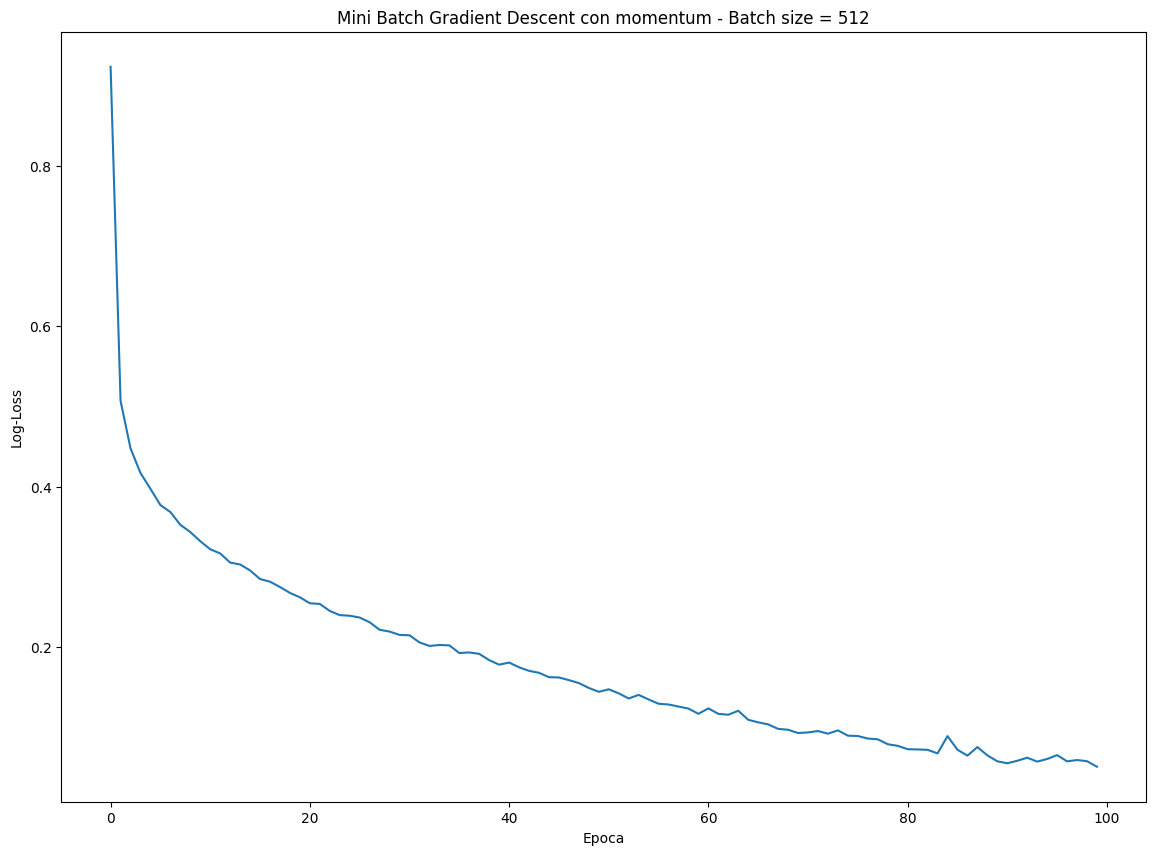

In [26]:
plt.figure(figsize=(14,10))
plt.title("Mini Batch Gradient Descent con momentum - Batch size = 512")
plt.xlabel("Epoca")
plt.ylabel("Log-Loss")
plt.plot(history.history['loss'])